In [ ]:
# code modified from digital historian 
# https://programminghistorian.org/en/lessons/introduction-to-stylometry-with-python

In [88]:
papers = {
    'Stephen': ['stephen_misery', 'stephen_it', 
                'stephen_bag_of_bones', 'stephen_insomnia', 
                'stephen_the_shining'],
    'Richard': ['richard_rage', 'richard_long_walk', 
                'richard_regulators', 'richard_running_man', 
                'richard_thinner', ],
    'Disputed': ['richard_roadwork'],
    'TestCase': ['stephen_pet_sementary']
}

In [90]:
import os
import matplotlib

In [91]:
books_dir = 'books'

for filename in os.listdir(books_dir):
    if filename.endswith('.txt'):
        print(os.path.join(books_dir, filename))

books/stephen_misery.txt
books/richard_regulators.txt
books/richard_rage.txt
books/stephen_it.txt
books/richard_long_walk.txt
books/richard_roadwork.txt
books/stephen_pet_sementary.txt
books/richard_running_man.txt
books/stephen_bag_of_bones.txt
books/stephen_insomnia.txt
books/stephen_the_shining.txt
books/richard_thinner.txt


In [92]:
# A function that compiles all of the text files associated with a single author into a single string
def read_files_into_string(filenames):
    strings = []
    for filename in filenames:
        with open(f'books/{filename}.txt', 'r') as f:
            strings.append(f.read())
    return '\n'.join(strings)

In [93]:
# Make a dictionary out of the authors' corpora
books_by_author = {}
for author, files in papers.items():
    books_by_author[author] = read_files_into_string(files)

In [94]:
#prints section of authors' books to show we have actual words saved
for author in papers:
    print(books_by_author[author][2000:2100])

 she is more than a rabid reader—she is Paul’s nurse, tending his 
shattered body after an automobil
e and Ted Jones. I 
was keeping an eye on him, I can tell you. The squirrel, not Ted. 

On the board
 
The Green Mile 
THE DARK TOWER IV: 
Wizard and Glass 
Bag of Bones 
The Girl Who Loved Tom 
Gordon
s a person ... or, more properly, as a 
Person. 

Here are some people who have not written books, t


[nltk_data] Downloading package punkt to /Users/nadim/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


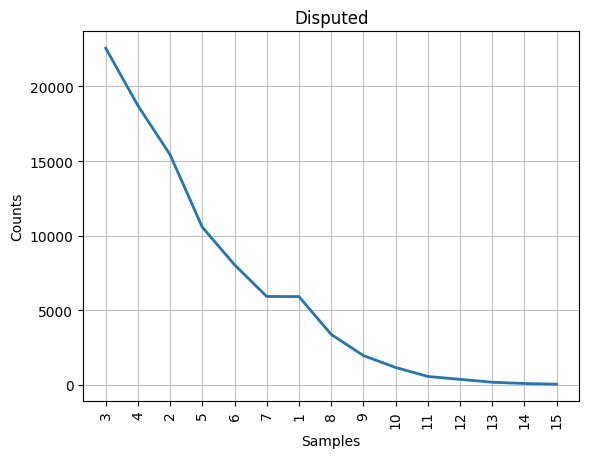

<Axes: title={'center': 'Disputed'}, xlabel='Samples', ylabel='Counts'>

In [95]:
# Load nltk
import nltk
nltk.download('punkt')
%matplotlib inline

# Compare the disputed papers to those written by everyone,
# including the shared ones.
authors = ("Stephen", "Richard", "Disputed")

# Transform the authors' corpora into lists of word tokens
books_by_author_tokens = {}
books_by_author_length_distributions = {}
for author in authors:
    tokens = nltk.word_tokenize(books_by_author[author])

    # Filter out punctuation
    books_by_author_tokens[author] = ([token for token in tokens
                                            if any(c.isalpha() for c in token)])

# Get a distribution of token lengths
token_lengths = [len(token) for token in books_by_author_tokens[author]]
books_by_author_length_distributions[author] = nltk.FreqDist(token_lengths)
books_by_author_length_distributions[author].plot(15,title=author)

In [96]:
# Who are the authors we are analyzing?
authors = ("Stephen", "Richard")

# Lower case the tokens so that the same word, capitalized or not,
# counts as one word
for author in authors:
    books_by_author_tokens[author] = (
        [token.lower() for token in books_by_author_tokens[author]])
books_by_author_tokens["Disputed"] = (
    [token.lower() for token in books_by_author_tokens["Disputed"]])

# Calculate chisquared for each of the two candidate authors
for author in authors:

    # First, build a joint corpus and identify the 500 most frequent words in it
    joint_corpus = (books_by_author_tokens[author] +
                    books_by_author_tokens["Disputed"])
    joint_freq_dist = nltk.FreqDist(joint_corpus)
    most_common = list(joint_freq_dist.most_common(500))

    # What proportion of the joint corpus is made up
    # of the candidate author's tokens?
    author_share = (len(books_by_author_tokens[author])
                    / len(joint_corpus))

    # Now, let's look at the 500 most common words in the candidate
    # author's corpus and compare the number of times they can be observed
    # to what would be expected if the author's papers
    # and the Disputed papers were both random samples from the same distribution.
    chisquared = 0
    for word,joint_count in most_common:

        # How often do we really see this common word?
        author_count = books_by_author_tokens[author].count(word)
        disputed_count = books_by_author_tokens["Disputed"].count(word)

        # How often should we see it?
        expected_author_count = joint_count * author_share
        expected_disputed_count = joint_count * (1-author_share)

        # Add the word's contribution to the chi-squared statistic
        chisquared += ((author_count-expected_author_count) *
                       (author_count-expected_author_count) /
                       expected_author_count)

        chisquared += ((disputed_count-expected_disputed_count) *
                       (disputed_count-expected_disputed_count)
                       / expected_disputed_count)

    print("The Chi-squared statistic for candidate", author, "is", chisquared)

The Chi-squared statistic for candidate Stephen is 6485.281708353993
The Chi-squared statistic for candidate Richard is 6256.548363420384


In [97]:
# Who are we dealing with this time?
authors = ("Stephen", "Richard", "Disputed")

# Convert papers to lowercase to count all tokens of the same word together
# regardless of case
for author in authors:
    books_by_author_tokens[author] = (
        [tok.lower() for tok in books_by_author_tokens[author]])

# Combine every paper except our test case into a single corpus
whole_corpus = []
for author in authors:
    whole_corpus += books_by_author_tokens[author]

# Get a frequency distribution
whole_corpus_freq_dist = list(nltk.FreqDist(whole_corpus).most_common(30))
whole_corpus_freq_dist[ :3 ]

[('the', 89216), ('and', 47675), ('a', 39898)]

In [98]:
# The main data structure
features = [word for word,freq in whole_corpus_freq_dist]
feature_freqs = {}

for author in authors:
    # A dictionary for each candidate's features
    feature_freqs[author] = {}

    # A helper value containing the number of tokens in the author's subcorpus
    overall = len(books_by_author_tokens[author])

    # Calculate each feature's presence in the subcorpus
    for feature in features:
        presence = books_by_author_tokens[author].count(feature)
        feature_freqs[author][feature] = presence / overall

In [99]:
import math

# The data structure into which we will be storing the "corpus standard" statistics
corpus_features = {}

# For each feature...
for feature in features:
    # Create a sub-dictionary that will contain the feature's mean
    # and standard deviation
    corpus_features[feature] = {}

    # Calculate the mean of the frequencies expressed in the subcorpora
    feature_average = 0
    for author in authors:
        feature_average += feature_freqs[author][feature]
    feature_average /= len(authors)
    corpus_features[feature]["Mean"] = feature_average

    # Calculate the standard deviation using the basic formula for a sample
    feature_stdev = 0
    for author in authors:
        diff = feature_freqs[author][feature] - corpus_features[feature]["Mean"]
        feature_stdev += diff*diff
    feature_stdev /= (len(authors) - 1)
    feature_stdev = math.sqrt(feature_stdev)
    corpus_features[feature]["StdDev"] = feature_stdev

In [100]:
feature_zscores = {}
for author in authors:
    feature_zscores[author] = {}
    for feature in features:

        # Z-score definition = (value - mean) / stddev
        # We use intermediate variables to make the code easier to read
        feature_val = feature_freqs[author][feature]
        feature_mean = corpus_features[feature]["Mean"]
        feature_stdev = corpus_features[feature]["StdDev"]
        feature_zscores[author][feature] = ((feature_val-feature_mean) /
                                            feature_stdev)

In [101]:
# Tokenize the test case
testcase_tokens = nltk.word_tokenize(books_by_author["TestCase"])

# Filter out punctuation and lowercase the tokens
testcase_tokens = [token.lower() for token in testcase_tokens
                   if any(c.isalpha() for c in token)]

# Calculate the test case's features
overall = len(testcase_tokens)
testcase_freqs = {}
for feature in features:
    presence = testcase_tokens.count(feature)
    testcase_freqs[feature] = presence / overall

# Calculate the test case's feature z-scores
testcase_zscores = {}
for feature in features:
    feature_val = testcase_freqs[feature]
    feature_mean = corpus_features[feature]["Mean"]
    feature_stdev = corpus_features[feature]["StdDev"]
    testcase_zscores[feature] = (feature_val - feature_mean) / feature_stdev
    print("Test case z-score for feature", feature, "is", testcase_zscores[feature])

Test case z-score for feature the is -1.0754820913966288
Test case z-score for feature and is 10.775555060653112
Test case z-score for feature a is -1.3132871322678086
Test case z-score for feature of is 0.21095161777432678
Test case z-score for feature to is 3.0637768712464655
Test case z-score for feature he is 0.4578013489122121
Test case z-score for feature was is 1.7146665059895867
Test case z-score for feature it is 1.9675032959395549
Test case z-score for feature i is -41.40690183837475
Test case z-score for feature in is -0.5814818697427473
Test case z-score for feature his is 1.7124043453904219
Test case z-score for feature that is 1.3335734344943508
Test case z-score for feature you is -1.1951516212892404
Test case z-score for feature had is 1.8777524034505373
Test case z-score for feature s is 1.638941067285244
Test case z-score for feature on is -0.3811369998033238
Test case z-score for feature t is -5.120845166063623
Test case z-score for feature she is 0.7563998909506499


In [102]:
for author in authors:
    delta = 0
    for feature in features:
        delta += math.fabs((testcase_zscores[feature] -
                            feature_zscores[author][feature]))
    delta /= len(features)
    print( "Delta score for candidate", author, "is", delta )

Delta score for candidate Stephen is 2.903099107601245
Delta score for candidate Richard is 3.0392335945901814
Delta score for candidate Disputed is 3.291663727184468
